In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ver = 'v40_cerberus'
ab = 'TPM_allGene.tsv'

## Get TPM on the sample level

Calculating short-read gene TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 58780
# genes >= 1 tpm: 36716
Applying gene type subset
Number of genes reported: 33297
Found 136 total samples


<Figure size 432x288 with 0 Axes>

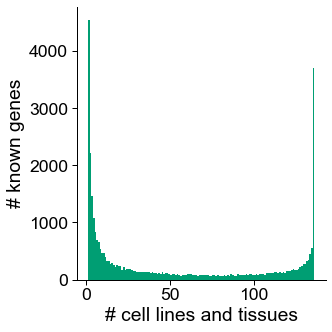

In [3]:
df = pd.read_csv(ab, sep='\t')
df = plot_biosamp_det(df,
                 how='sr',
                 min_tpm=1,
                 gene_subset='polya',
                 sample=None,
                 groupby='sample',
                 opref='figures/human')


Calculating short-read gene TPM values
Subsetting for polya genes
Applying gene type subset
Number of genes reported: 49093
Detected 49093 / 52274 (93.9%) annotated polyA genes
protein_coding
94.21652991795078

lncRNA
52.101645255803476

pseudogene
35.89214472417114



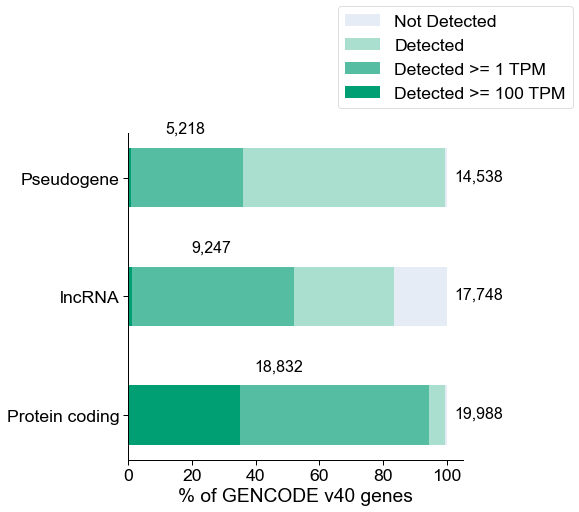

In [4]:
df = pd.read_csv(ab, sep='\t')
plot_gene_det_by_biotype_tpm(df, how='sr', ver=ver)

## PolyA gene detection at 0, 1, and 100 TPM

In [101]:
df = pd.read_csv('TPM_allGene.tsv', sep='\t')
df.drop('biotype_category', axis=1, inplace=True)
df['gid_stable'] = cerberus.get_stable_gid(df, 'gene_id')
df.set_index('gid_stable', inplace=True)
df.drop('gene_id', axis=1, inplace=True)

In [102]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene',
                                               ver=ver)

In [103]:
df.head()

,ENCFF026RBK,ENCFF785OAV,ENCFF307CQG,ENCFF594PJE,ENCFF768JVA,ENCFF606WIM,ENCFF118MYS,ENCFF980YEK,ENCFF994LBK,ENCFF268MYA,...,ENCFF492RBW,ENCFF090JUO,ENCFF489CHJ,ENCFF932VTY,ENCFF221IRL,ENCFF278GBV,ENCFF471MPG,ENCFF007ABB,ENCFF297SFW,ENCFF948IEB
gid_stable,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.27,0.70,0.00,0.15,0.63,0.00,1.08,0.09,0.32,0.02,...,0.62,0.79,5.03,20.05,5.58,2.51,2.17,9.10,6.52,7.95
ENSG00000000005,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.04,0.02,0.41,0.00,0.06,0.00
ENSG00000000419,31.64,16.19,26.80,33.90,16.04,19.77,17.93,36.80,13.72,18.38,...,12.90,26.26,12.61,9.62,12.38,8.37,18.75,23.21,18.69,24.37
ENSG00000000457,6.83,1.26,6.38,5.91,8.43,6.69,7.65,4.45,8.08,6.79,...,7.12,3.05,4.14,3.94,5.11,3.55,2.26,2.08,1.56,1.87
ENSG00000000460,14.80,1.03,14.16,12.69,3.69,14.44,2.37,13.34,2.66,14.85,...,2.29,6.11,2.58,1.07,1.64,1.37,0.43,3.98,3.77,2.47


In [104]:
tpm_df = df.copy(deep=True)
tpm_dfs = []
tpm_dfs.append(tpm_df)
tpm_dfs.append(tpm_df.loc[(tpm_df >= 1).any(axis=1)])
tpm_dfs.append(tpm_df.loc[(tpm_df >= 100).any(axis=1)])

det_df = pd.DataFrame()
for df, tpm in zip(tpm_dfs, [0,1,100]):
    gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'gname', 'biotype_category']]

    df.reset_index(inplace=True)
    df = df.merge(gene_df, how='left', on='gid_stable')

    df = df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    df.rename({'gid_stable':'obs_counts'}, axis=1, inplace=True)

    gene_df = gene_df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
    gene_df.rename({'gid_stable':'annot_counts'}, axis=1, inplace=True)
    df = df.merge(gene_df, how='left', left_index=True, right_index=True)

    df['perc'] = (df.obs_counts/df.annot_counts)*100
    df = df.sort_values(by='perc', ascending=False)
    df['tpm_thresh'] = tpm
    det_df = pd.concat([det_df, df])
    
det_df = det_df.reset_index()
det_df.head()

,biotype_category,obs_counts,annot_counts,perc,tpm_thresh
0,pseudogene,14450,14538,99.394690,0
1,protein_coding,19837,19988,99.244547,0
2,lncRNA,14806,17748,83.423484,0
3,protein_coding,18832,19988,94.216530,1
4,lncRNA,9247,17748,52.101645,1


protein_coding
94.21652991795078

lncRNA
52.101645255803476

pseudogene
35.89214472417114



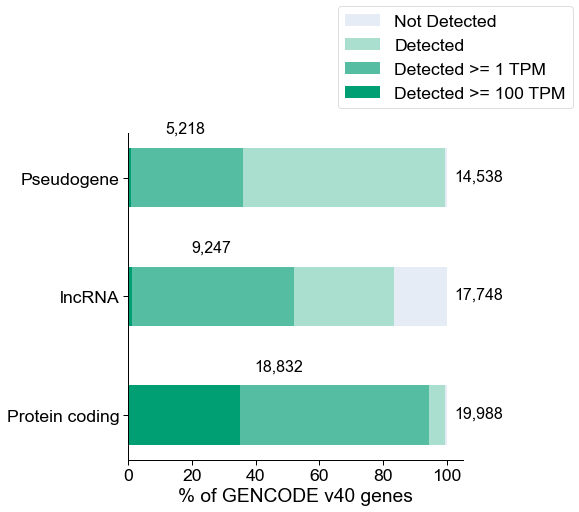

In [106]:
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(6,6))
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
ic_colors, order = get_ic_nov_colors()
gray = get_sector_colors()[0]['simple']
c = ic_colors['Known']
cats = [100,1,0]
c_dict, order = get_shade_colors(c, cats)
order.reverse()
biotypes = ['protein_coding', 'lncRNA', 'pseudogene']
b_dict = {'protein_coding': 'Protein coding',
          'lncRNA': 'lncRNA',
          'pseudogene': 'Pseudogene'}

# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def add_n(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_y()+rect.get_height()/2.5
        y = rect.get_width()*1.1
        ax.text(y,x,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)
        
def add_n_2(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_y()+rect.get_height()*1.2
        y = rect.get_width()/2
        ax.text(y,x,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)

for b in biotypes:
    x = b_dict[b]
    y = 0
    rects = plt.barh(x, [100], color=gray, height=0.5)
    # add total number of genes
    n = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==1), 'annot_counts'].tolist()[0]
    add_n(rects, n)
    
    for c in order:
        curr_y = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==c), 'perc'].tolist()[0]           
        rects = plt.barh(x, [curr_y], color=c_dict[c], height=0.5)
        if c == 1:
            n = det_df.loc[(det_df.biotype_category == b)&(det_df.tpm_thresh==1), 'obs_counts'].tolist()[0]
            add_n_2(rects, n)
            print(b)
            print(curr_y)
            print()
        y = y+curr_y
    


leg_labels = ['Not Detected', 'Detected', 'Detected >= 1 TPM', 'Detected >= 100 TPM']
plt.legend(leg_labels, bbox_to_anchor=(.6, 1.05))
ax = plt.gca()
leg = ax.get_legend()

# plt.yticks(rotation=90)

# plt.ylabel('Biotype')
plt.xlabel('% of GENCODE v40 genes')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fname = 'figures/gene_det_by_biotype.png'
plt.savefig(fname, dpi=500, bbox_inches='tight')
fname = 'figures/gene_det_by_biotype.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')

In [3]:
df = pd.DataFrame()
df['expressed'] = [19911,14665,12997,4295]
df['expressed_tpm'] = [18949,9382,5236,3149]
df['total'] = [19969,15006,14497,9217]

In [4]:
df['biotype'] = ['protein_coding', 'lncRNA', 'pseudogene', 'other']

In [5]:
df.head()

,expressed,expressed_tpm,total,biotype
0,19911,18949,19969,protein_coding
1,14665,9382,15006,lncRNA
2,12997,5236,14497,pseudogene
3,4295,3149,9217,other


In [6]:
df['e_prop'] = df.expressed/df.total
df['e_tpm_prop'] = df.expressed_tpm/df.total

In [8]:
df.set_index('biotype', inplace=True)
df = df.transpose()
df.head()


biotype,protein_coding,lncRNA,pseudogene,other
expressed,19911.000000,14665.000000,12997.000000,4295.000000
expressed_tpm,18949.000000,9382.000000,5236.000000,3149.000000
total,19969.000000,15006.000000,14497.000000,9217.000000
e_prop,0.997095,0.977276,0.896530,0.465987
e_tpm_prop,0.948921,0.625217,0.361178,0.341651


In [9]:
df = df.loc[['e_prop', 'e_tpm_prop']]

In [15]:
df.head()

biotype,protein_coding,lncRNA,pseudogene,other
e_prop,0.997095,0.977276,0.896530,0.465987
e_tpm_prop,0.948921,0.625217,0.361178,0.341651


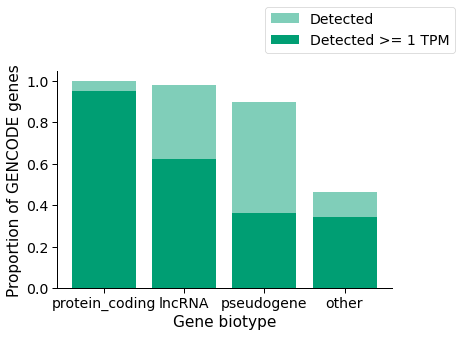

In [46]:
sns.set_context('paper', font_scale=1.6)
ic_colors, order = get_ic_nov_colors()

c = ic_colors['Known']
cats = df.columns.tolist()
c_dict, order = get_shade_colors(c, ['e_tpm_prop', 'e_prop'])
order.reverse()
for biotype in cats:
    x = [biotype]
    y = 0
    for cat in order:
        curr_y = df.loc[cat, biotype]
        # print('curr_y: ', curr_y)
        # print('y: ', y)
        # print()
        plt.bar(x, [curr_y], color=c_dict[cat])
        y = y+curr_y
    
    
leg_labels = ['Detected', 'Detected >= 1 TPM']
plt.legend(leg_labels, bbox_to_anchor=(.6, 1.05))
ax = plt.gca()
leg = ax.get_legend()
# c_dict, order = get_shade_colors('#000000', leg_labels)
# for i, nov in enumerate(order):
#     leg.legendHandles[i].set_color(c_dict[nov])
plt.xlabel('Gene biotype')
plt.ylabel('Proportion of GENCODE genes')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    

In [20]:
df.loc['e_prop', 'protein_coding']

0.997095498021934

In [18]:
df

biotype,protein_coding,lncRNA,pseudogene,other
e_prop,0.997095,0.977276,0.896530,0.465987
e_tpm_prop,0.948921,0.625217,0.361178,0.341651
